# 3D Image Classification from CT Scans

**Author:** [Hasib Zunair](https://twitter.com/hasibzunair)<br>
**Date created:** 2020/09/23<br>
**Last modified:** 2020/09/23<br>
**Description:** Train a 3D convolutional neural network to predict presence of pneumonia.

## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

In [1]:
# tf2 environment
import os
import glob
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. CT scans store raw voxel
intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.
Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [2]:

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    # min = -1000
    # max = 400
    # volume[volume < min] = min
    # volume[volume > max] = max
    # volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # No normalization want to keep values from -1 to 1, only converts to float32
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


Let's read the paths of the MRI scans from the class directories.

In [3]:
# Folder "intra" consists of MRI scans from intra-registration and "inter" from inter-registration pairs.

path = '/home/andjela/Documents/intra-inter-ddfs'
intra_scan_paths = glob.glob(f"{path}/intra/**/logJacobian.nii.gz", recursive=True)

inter_scan_paths = glob.glob(f"{path}/inter/**/logJacobian.nii.gz", recursive=True)

print("MRI scans with intra log Jacobian: " + str(len(intra_scan_paths)))
print("MRI scans with inter log Jacobian: " + str(len(inter_scan_paths)))


MRI scans with intra log Jacobian: 434
MRI scans with inter log Jacobian: 421


## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [4]:
from sklearn.model_selection import train_test_split
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
intra_scans = np.array([process_scan(path) for path in intra_scan_paths])
inter_scans = np.array([process_scan(path) for path in inter_scan_paths])

# For the MRI scans having a logJacobian derived from intra reg
# assign 1, for inter assign 0.
intra_labels = np.array([1 for _ in range(len(intra_scans))])
inter_labels = np.array([0 for _ in range(len(inter_scans))])

# Split data in the ratio 70-30 for training and validation.
X = np.concatenate((intra_scans, inter_scans), axis=0)
y = np.concatenate((intra_labels, inter_labels), axis=0)
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 598 and 257.


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [28]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < -1] = -1
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [6]:
print(x_train.shape, y_train.shape)

(598, 128, 128, 64) (598,)


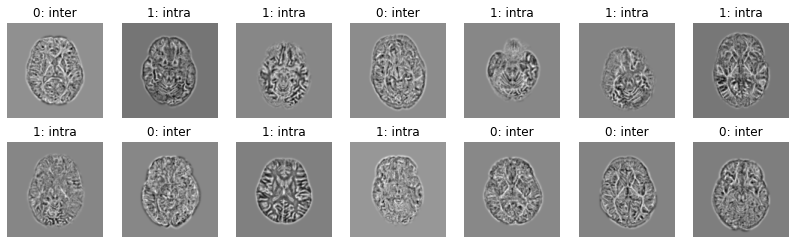

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 7, figsize=(14, 4))

for i in range(14):
    row = i // 7
    col = i % 7
    image = x_train[i, :, :, :]
    label = y_train[i]
    axes[row, col].imshow(np.squeeze(image[:, :, 32]), cmap='gray')
    if label == 1:
        axes[row, col].set_title("1: intra")
    elif label == 0:
        axes[row, col].set_title("0: inter")
    axes[row, col].axis('off')

plt.show()


While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [32]:
# Define data loaders.
print(type(x_train[0]))
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

<class 'numpy.ndarray'>


Visualize an augmented CT scan.

Dimension of the MRI scan is: (128, 128, 64, 1)


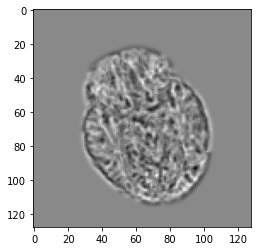

In [33]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


Since a CT scan has many slices, let's visualize a montage of the slices.

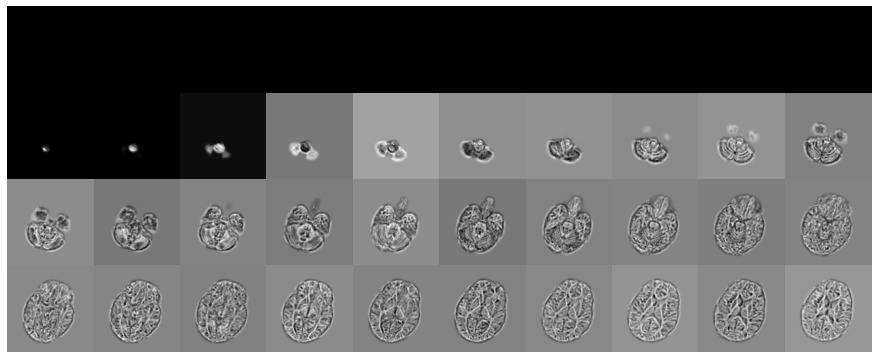

In [34]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [11]:

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

## Train model

In [35]:
log_dir = os.path.join(os.getcwd(), "logs")
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_epoch{epoch:02d}.h5",
    save_best_only=True,
    monitor='val_loss',  # Set the metric to monitor, typically validation loss
    verbose=1,  # Set to 1 to receive a message when a new best model is saved
    mode='min'  # Set to 'min' if you are monitoring a metric like validation loss
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Add the TensorBoard callback to the list of callbacks
callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]  # Include other callbacks as well

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=callbacks,
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.80598, saving model to 3d_image_classification_epoch01.h5
299/299 - 63s - loss: 0.4238 - acc: 0.7492 - val_loss: 0.8060 - val_acc: 0.5564
Epoch 2/100

Epoch 00002: val_loss improved from 0.80598 to 0.14607, saving model to 3d_image_classification_epoch02.h5
299/299 - 60s - loss: 0.3279 - acc: 0.8378 - val_loss: 0.1461 - val_acc: 0.9533
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.14607
299/299 - 59s - loss: 0.2824 - acc: 0.8629 - val_loss: 0.1558 - val_acc: 0.9611
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.14607
299/299 - 59s - loss: 0.2673 - acc: 0.8796 - val_loss: 0.2468 - val_acc: 0.8638
Epoch 5/100

Epoch 00005: val_loss improved from 0.14607 to 0.10132, saving model to 3d_image_classification_epoch05.h5
299/299 - 59s - loss: 0.2382 - acc: 0.9047 - val_loss: 0.1013 - val_acc: 0.9883
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.10132
299/299 - 59s - loss: 0.1862 - acc: 0.9298 - val_los

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

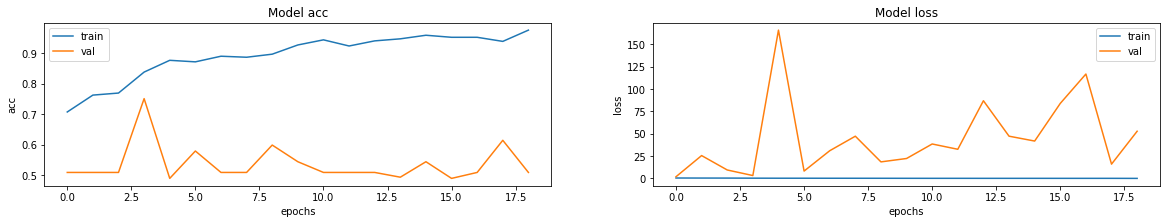

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single MRI scan

In [26]:
print('x_val shape', x_val.shape)
img_number = 256
img_to_predict = x_val[img_number]
# 1 is for intra and 0 is for inter
y_val_to_be_predicted = y_val[img_number]
epoch = '08'
model.load_weights(f"3d_image_classification_epoch{epoch}.h5")
prediction = model.predict(np.expand_dims(img_to_predict, axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["inter", "intra"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

(257, 128, 128, 64)
This model is 0.64 percent confident that MRI scan is inter
This model is 99.36 percent confident that MRI scan is intra


In [ ]:
class_names = ["inter", "intra"]
correct_predictions = 0

for sample_index in range(x_val.shape[0]):
    img_to_predict = x_val[sample_index].reshape(1, *x_val[sample_index].shape)
    true_class = y_val[sample_index]

    prediction = model.predict(img_to_predict)[0]
    predicted_class = 1 if prediction[0] >= 0.5 else 0  # Assuming a threshold of 0.5

    predicted_class_name = class_names[predicted_class]
    true_class_name = class_names[true_class]

    if predicted_class == true_class:
        print(f"Sample {sample_index}: The model correctly predicted the MRI scan as {predicted_class_name}.")
        correct_predictions += 1
    else:
        print(f"Sample {sample_index}: The model predicted the MRI scan as {predicted_class_name}, but the true class is {true_class_name}.")

accuracy_percentage = (correct_predictions / x_val.shape[0]) * 100
print(f"Accuracy: {accuracy_percentage:.2f}% ({correct_predictions}/{x_val.shape[0]} samples were correct).")
